# Approximated Gaussian Process regression

In this file, we make use of the lower bound optimization that we implemented in utils_gradientGP.py to compute a regression on the PM2.5 data.

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.datasets import mnist
from keras.optimizers import RMSprop
from keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import os
from tqdm import tqdm
import pandas as pd

from utils_gradientGP import *


Using TensorFlow backend.


In [2]:
path = 'data/FiveCitiePMData'
"""
data = []
for f in os.listdir(path):
    print(f)
    data.append(pd.read_csv(path + '/'+ f))
    """

"\ndata = []\nfor f in os.listdir(path):\n    print(f)\n    data.append(pd.read_csv(path + '/'+ f))\n    "

## Cleaning the dataset 

We will try to make a regression on the PM_US Post values with some continuous and categorical variables in the dataset

In [3]:
beijing = pd.read_csv(path + '/' + 'BeijingPM20100101_20151231.csv')
print(list(beijing))
np.sum(pd.isna(beijing['PM_Nongzhanguan']))
# removing the 
missing_uspost = [not(e) for e in list(pd.isna(beijing['PM_US Post'], ))]
beijing_cl = beijing[missing_uspost]

features = ['year', 'month', 'day', 'hour', 'season', 'DEWP', 'HUMI', 'PRES', 'TEMP','Iws', 'precipitation', 'Iprec']

['No', 'year', 'month', 'day', 'hour', 'season', 'PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan', 'PM_US Post', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'cbwd', 'Iws', 'precipitation', 'Iprec']


In [4]:
# check for nas
for e in features:
    print(e, ':', np.sum(pd.isna(beijing_cl[e])), 'nas')

year : 0 nas
month : 0 nas
day : 0 nas
hour : 0 nas
season : 0 nas
DEWP : 5 nas
HUMI : 339 nas
PRES : 339 nas
TEMP : 5 nas
Iws : 5 nas
precipitation : 473 nas
Iprec : 473 nas


In [5]:
# removing the rows for which there are NA
beijing_cl2 = beijing_cl[features + ['PM_US Post' ]].dropna(how = 'any')
X_df = beijing_cl2[features]
y_df = beijing_cl2['PM_US Post']

In [6]:
# checking another time for nas
for e in features:
    print(e, ':', np.sum(pd.isna(X_df[e])), "nas")

print('PM_US Post :', np.sum(pd.isna(y_df)), 'nas')

year : 0 nas
month : 0 nas
day : 0 nas
hour : 0 nas
season : 0 nas
DEWP : 0 nas
HUMI : 0 nas
PRES : 0 nas
TEMP : 0 nas
Iws : 0 nas
precipitation : 0 nas
Iprec : 0 nas
PM_US Post : 0 nas


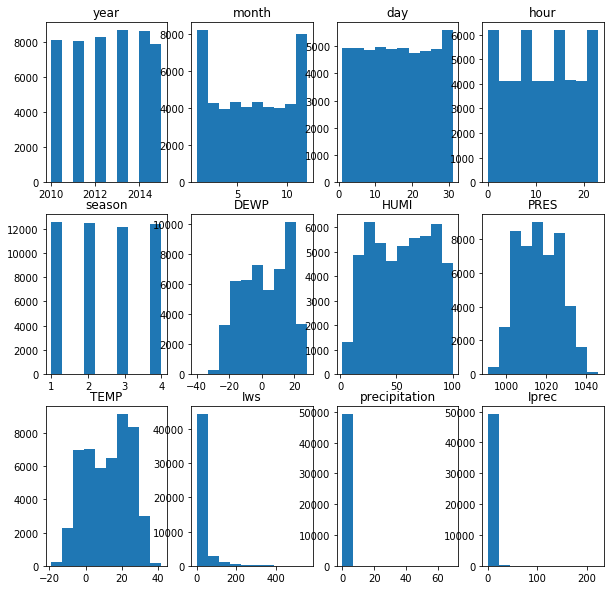

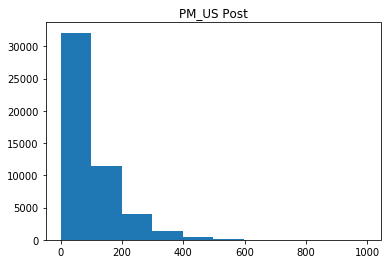

In [7]:
plt.figure(figsize= (10,10))

for i,e in enumerate(list(X_df)):
    plt.subplot(3,4,i+1)
    plt.hist(X_df[e], )
    plt.title(e)
plt.show()

plt.hist(y_df)
plt.title("PM_US Post")
plt.show()

In [8]:
# converting to numpy arrays
X = X_df.values
y = y_df.values

In [9]:
nb_samples = 1500
X_train, X_test, y_train, y_test = train_test_split(X[:nb_samples,], y[:nb_samples,], test_size = 0.2, shuffle = False)
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))
print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)

X train shape:  (1200, 12)
y train shape:  (1200, 1)
X test shape:  (300, 12)
y test shape:  (300, 1)


In [10]:
X_train_scale = scale(X_train)
y_train_scale = scale(y_train)
X_test_scale = scale(X_test)
y_test_scale = scale(y_test)

## Using Gaussien Process and gradient descent

In [11]:
GP = Gaussian_Process()
DROP_OUT = 0.25
p = 1 - DROP_OUT
N = X_train_scale.shape[0]
# l2 regularization
lambd = 0.01
# precision parameter
TAU = DROP_OUT/(2*lambd*N)
print(N, TAU)

1200 0.010416666666666666


In [ ]:
pl = GP.fit(X_train_scale, y_train_scale, p1=p, p2=p, tau = TAU, verbose=True, max_iter=3000, alpha=0.001)

plt.plot(pl)
plt.show()

main loop:  58%|█████▊    | 1734/3000 [11:29<08:23,  2.52it/s]

In [15]:
GP.accuracy(X_test_scale, y_test_scale, p1=p, p2=p)

470.72924552224964

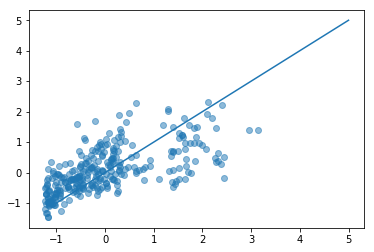

In [17]:
Y_pred = GP.predict(X_test_scale, p1=p, p2=p)
plt.scatter(y_test_scale[:,0], np.array(Y_pred)[:,0,0], alpha = 0.5)
plt.plot(np.arange(-1, 6),np.arange(-1, 6), )

plt.show()


## Plotting prediction

In [18]:
X_testdf = pd.DataFrame(X_test)
date_x_test = pd.to_datetime((X_testdf[0]*1000000+X_testdf[1]*10000+X_testdf[2]*100+X_testdf[3]).astype(int).apply(str),format='%Y%m%d%H')
Y_preddf = pd.DataFrame(np.array(Y_pred)[:,0,0])
Y_preddf['date'] = date_x_test
Y_preddf = Y_preddf.sort_values('date', ascending=True)

Y_testdf = pd.DataFrame(np.array(y_test_scale))
Y_testdf['date'] = date_x_test
Y_testdf = Y_testdf.sort_values('date', ascending=True)


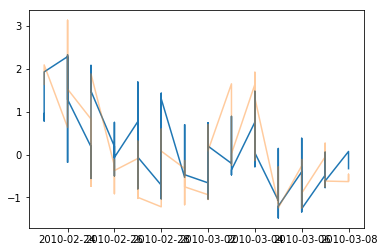

In [19]:
fig, ax = plt.subplots()

ax.plot(Y_preddf['date'], Y_preddf[0], label="Prediction")
ax.plot(Y_testdf['date'], Y_testdf[0], alpha=0.4, label="True value")

plt.show()